# User's guide to accessing PZ outputs directly from the DP1 butler

In [1]:
algo_1 = 'knn'
algo_2 = 'bpz'
flux_model = 'gaap1p0'
required_bands = 'griz'

Imports and butler set up

In [2]:
import numpy as np
import pandas as pd
from lsst.daf.butler import Butler
from astropy.table import Table, join
from astropy import units as u
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
butler = Butler('/repo/dp1')

In [4]:
pz_table = Table.read('https://data.lsdb.io/hats/dp1/object_photoz_no_mags.parquet')

Available algorithms

In [6]:
print(f'Available PZ algorithms in DP1: {[col_name.split('_')[0] for col_name in pz_table.columns if col_name.endswith('z_mode')]}')

Available PZ algorithms in DP1: ['lephare', 'knn', 'tpz', 'cmnn', 'gpz', 'bpz', 'dnf', 'fzboost']


Pull data from butler

In [7]:
obj_columns = ['objectId', 'coord_ra', 'coord_dec', 
               'g_extendedness', 'r_extendedness',
               f'u_{flux_model}Flux', f'g_{flux_model}Flux', 
               f'r_{flux_model}Flux', f'i_{flux_model}Flux', 
               f'z_{flux_model}Flux', f'y_{flux_model}Flux',
               f'u_{flux_model}FluxErr', f'g_{flux_model}FluxErr', 
               f'r_{flux_model}FluxErr', f'i_{flux_model}FluxErr', 
               f'z_{flux_model}FluxErr', f'y_{flux_model}FluxErr']
if flux_model != 'psf':
    obj_columns.append('i_psfFlux')
    obj_columns.append('i_psfFluxErr')

In [8]:
obj_table = butler.get('object', 
                       instrument='LSSTComCam', 
                       skymap='lsst_cells_v1', 
                       tract=5063, 
                       collections='LSSTComCam/DP1', 
                       parameters={'columns': obj_columns})

Object Table Cuts

In [9]:
obj_table = obj_table[(obj_table['g_extendedness'].mask > 0.5) | (obj_table['r_extendedness'].mask > 0.5)]

In [10]:
obj_table = obj_table[(obj_table['i_psfFlux'] / obj_table['i_psfFluxErr']) > 5.]

Join Tables

In [11]:
combined_table = join(pz_table, obj_table, keys_left='objectId', keys_right='objectId')

Calculate magnitudes and select six or four band objects

In [12]:
required_bands_present = [True] * len(combined_table)
band_list = ['u', 'g', 'r', 'i', 'z', 'y']
required_band_list = [band_label for band_label in required_bands]
for band_label in band_list:
    combined_table[f'{band_label}_{flux_model}Mag'] = \
        (combined_table[f'{band_label}_{flux_model}Flux']*u.nJy).to(u.ABmag)
    if band_label in required_band_list:
        required_bands_present *= ~np.isnan(combined_table[f'{band_label}_{flux_model}Mag'])

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [13]:
combined_table = combined_table[np.where(required_bands_present == True)]
print(f'Total number of objects with observations in all required bands ({required_band_list}): {len(combined_table)}')

Total number of objects with observations in all required bands (['g', 'r', 'i', 'z']): 32922


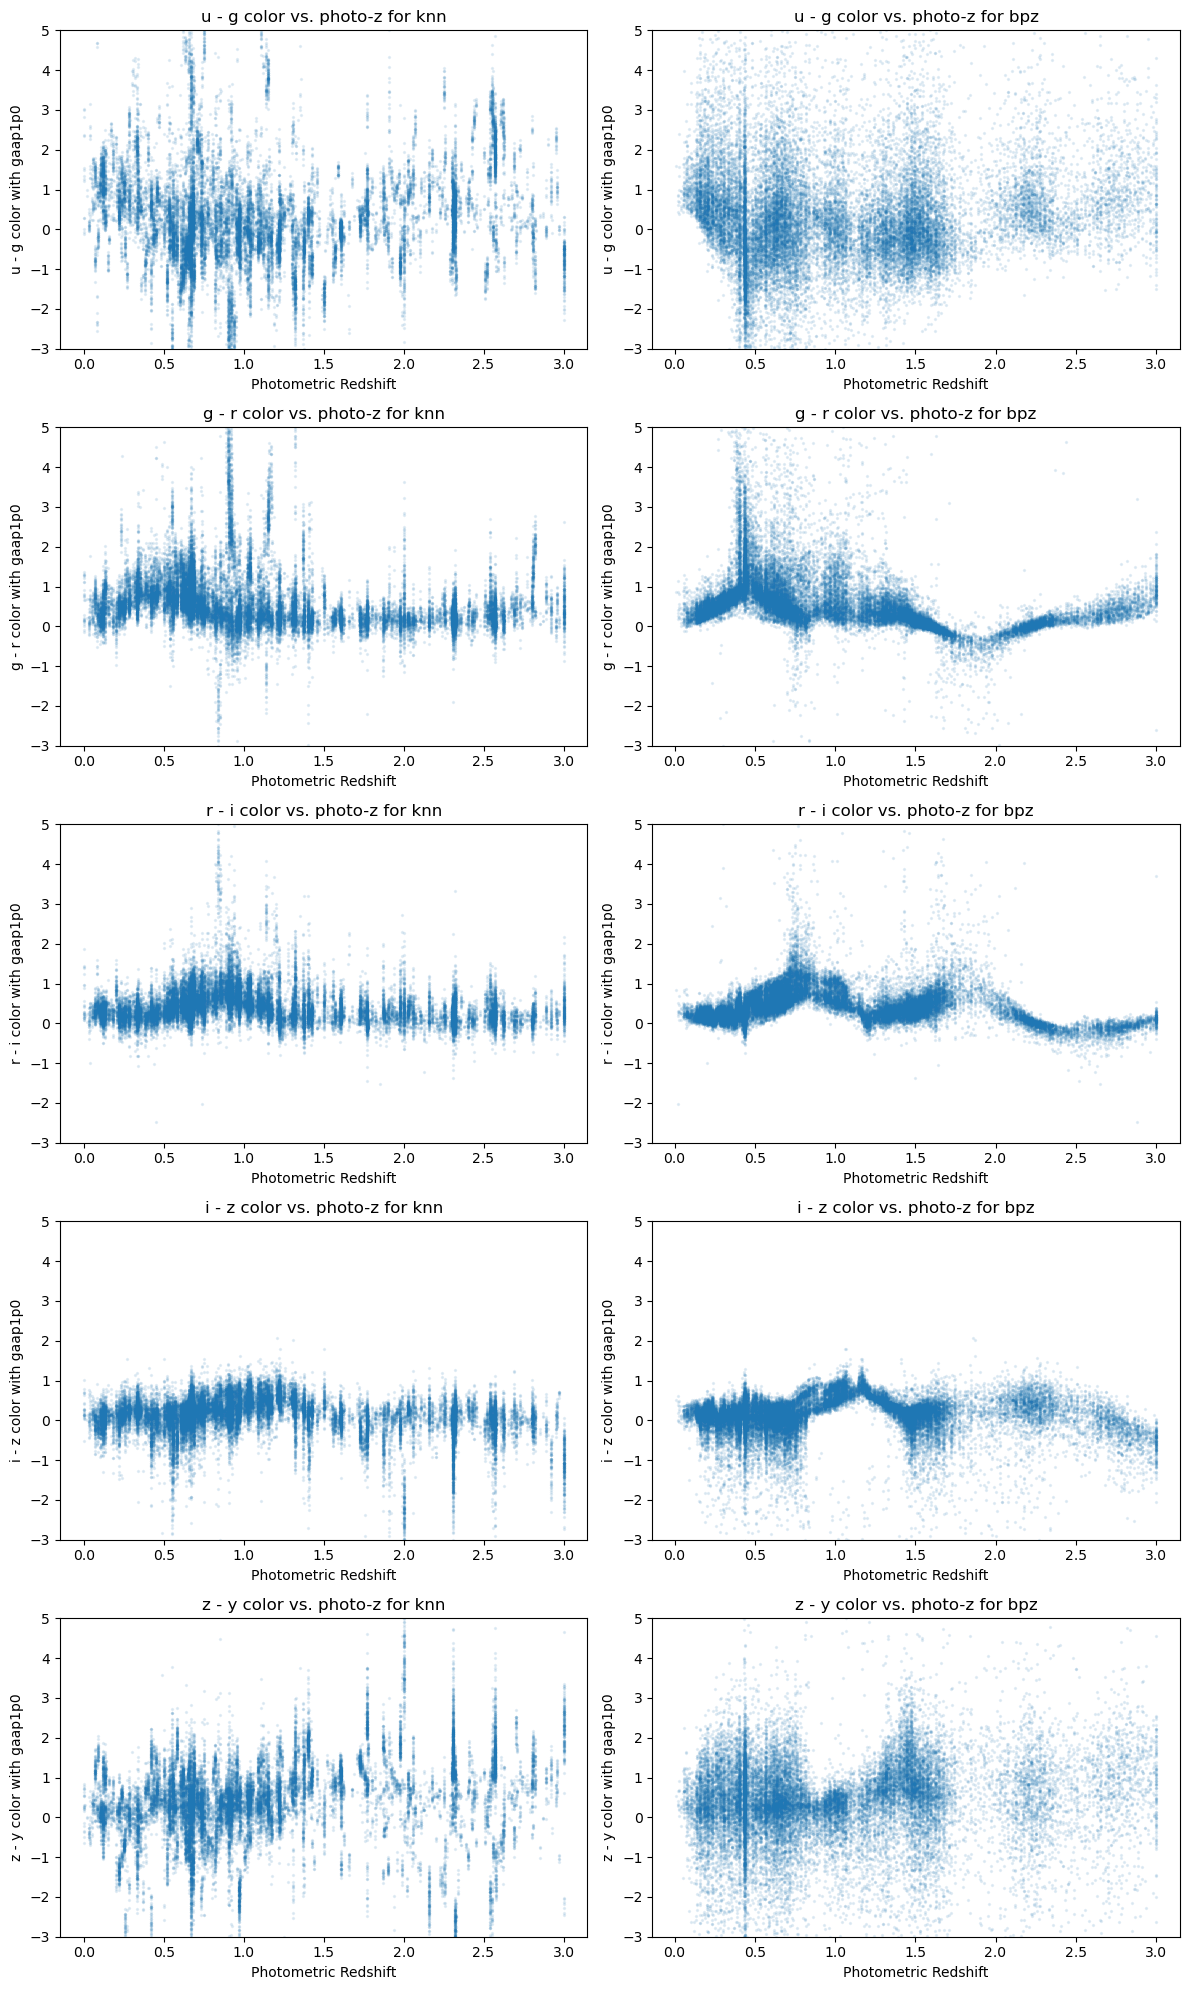

In [14]:
fig = plt.figure(figsize=(12, 20))
plot_idx = 1
for band_1, band_2 in zip(band_list[:-1], band_list[1:]):
    color_on = combined_table[f'{band_1}_{flux_model}Mag'] - combined_table[f'{band_2}_{flux_model}Mag']
    
    fig.add_subplot(5, 2, plot_idx) 
    plt.scatter(combined_table[f'{algo_1}_z_mode'], color_on, s=2, alpha=0.1)
    plt.title(f'{band_1} - {band_2} color vs. photo-z for {algo_1}')
    plt.ylim(-3, 5)
    plt.xlabel('Photometric Redshift')
    plt.ylabel(f'{band_1} - {band_2} color with {flux_model}')
    
    plot_idx += 1

    fig.add_subplot(5, 2, plot_idx) 
    plt.scatter(combined_table[f'{algo_2}_z_mode'], color_on, s=2, alpha=0.1)
    plt.title(f'{band_1} - {band_2} color vs. photo-z for {algo_2}')
    plt.ylim(-3, 5)
    plot_idx += 1
    plt.xlabel('Photometric Redshift')
    plt.ylabel(f'{band_1} - {band_2} color with {flux_model}')
plt.tight_layout()

Text(0, 0.5, 'Count')

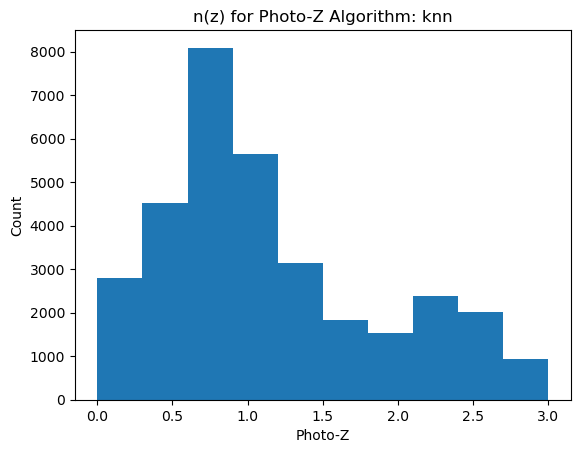

In [15]:
plt.hist(combined_table[f'{algo_1}_z_mode'])
plt.title(f'n(z) for Photo-Z Algorithm: {algo_1}')
plt.xlabel('Photo-Z')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

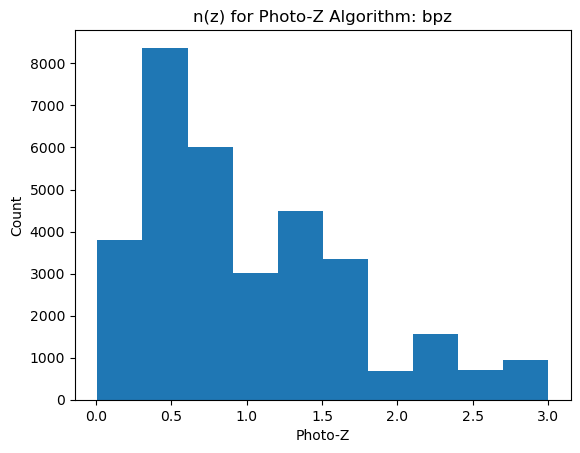

In [16]:
plt.hist(combined_table[f'{algo_2}_z_mode'])
plt.title(f'n(z) for Photo-Z Algorithm: {algo_2}')
plt.xlabel('Photo-Z')
plt.ylabel('Count')

Text(0.5, 1.0, 'Comparing n(z) for two algorithms')

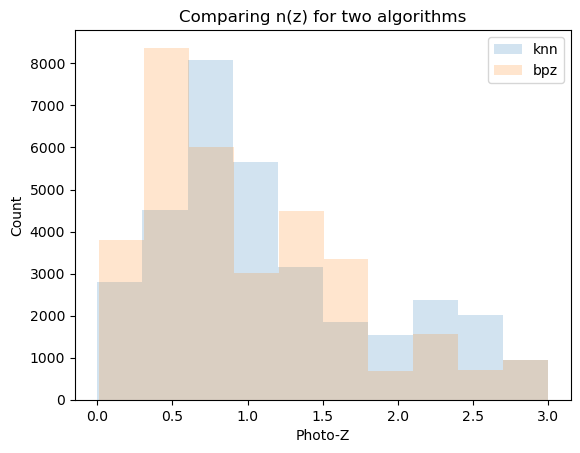

In [17]:
plt.hist(combined_table[f'{algo_1}_z_mode'], alpha=0.2, label=algo_1)
plt.hist(combined_table[f'{algo_2}_z_mode'], alpha=0.2, label=algo_2)
plt.legend()
plt.xlabel('Photo-Z')
plt.ylabel('Count')
plt.title('Comparing n(z) for two algorithms')